In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from discovery import Chen, LLR, UCB1

from discoveryV2 import Chen as ChenSUB
from discoveryV2 import LLR as LLRSUB


In [22]:
# Definimos la semilla para la replicabilidad del código
np.random.seed(666)

# Número de cuadrantes
M = 10 
# Cantidad de brazos (o policías)
K = 3
# Períodos de tiempo
T_max = 100
# Probabilidad de observar el crimen perfectamente en los cuadrantes no visitados
p = 0
# Media del crimen por cudrante
mu_reales = np.random.randint(low = 4, high = 100, size = M)
# Ahora vamos a encontrar rho que es la probabilidad de éxito de nuestra binomial
# N puede ser cualquier cosa pero dejamos un número interpretable
N = 1000
rho = mu_reales / N

# q = np.random.uniform(size=M)
q = .5 * np.ones(M)

chen = Chen(M, K, N, rho, q)
llr = LLR(M, K, N, q, rho, underreporting=False)
ucb1 =  UCB1(M, K, N, q, rho)

chen_sub = ChenSUB(M, K, N, rho, q)
llr_sub = LLRSUB(M, K, N, q, rho, underreporting=False)

## Chen (Subreporte)

In [23]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes
mu_hat = np.ones(M)

X_T = np.zeros((T_max, M))
X_T_sub = np.zeros((T_max, M))
X_T_sub[0] = np.random.binomial(N, .47, size=M)

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

historical_mu_bar = np.zeros((T_max, M))
for t in tqdm(range(T_max)):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat

    # update rule
    mu_bar = chen_sub.update_rule(t, mu_hat, T_i)
    historical_mu_bar[t - 1] = mu_bar
    
    #oracle
    S = chen_sub.oracle(mu_bar)

    # 0-index
    S_T[t - 1] = S
    T_i[S.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = chen_sub.update_mu_hat_t_i(S, X_T_sub, X_T, t, S_T, mu_hat)
    

100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


<AxesSubplot:>

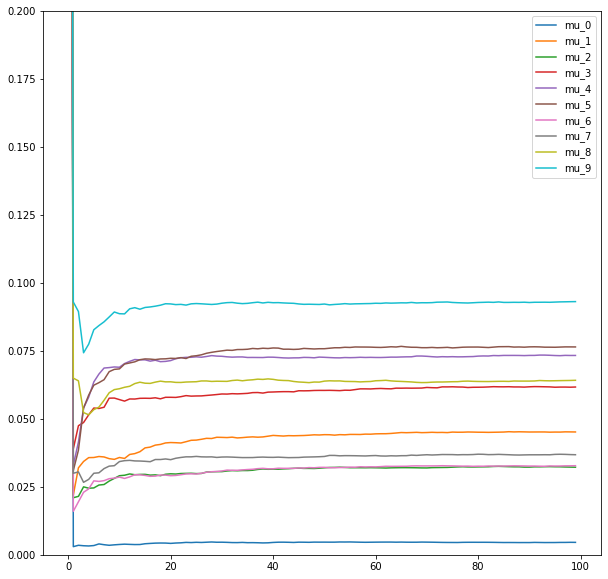

In [24]:
pd.DataFrame(historical_mu_hat, columns=[f'mu_{i}' for i in range(M)]).plot(figsize=(10, 10), ylim=(0,.2))

In [27]:
mu_hat

array([0.00457, 0.04512, 0.03224, 0.06176, 0.07325, 0.07655, 0.03278,
       0.03679, 0.06423, 0.09312])

In [28]:
rho

array([0.006, 0.049, 0.034, 0.066, 0.074, 0.077, 0.034, 0.04 , 0.065,
       0.095])

In [25]:
historical_mu_hat[100]

array([0.00393, 0.03735, 0.02834, 0.05774, 0.06055, 0.07997, 0.03745,
       0.03699, 0.06455, 0.08777])

## Learning with Linear Rewards (LLR - Subreporte)

In [18]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))
X_T_sub = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = llr.initialization(T_i)

for t in tqdm(range(T_max)):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat

    #oracle
    a = llr_sub.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = llr_sub.update_mu_hat(X_T, X_T_sub, a, t, S_T, mu_hat)
    

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


<AxesSubplot:>

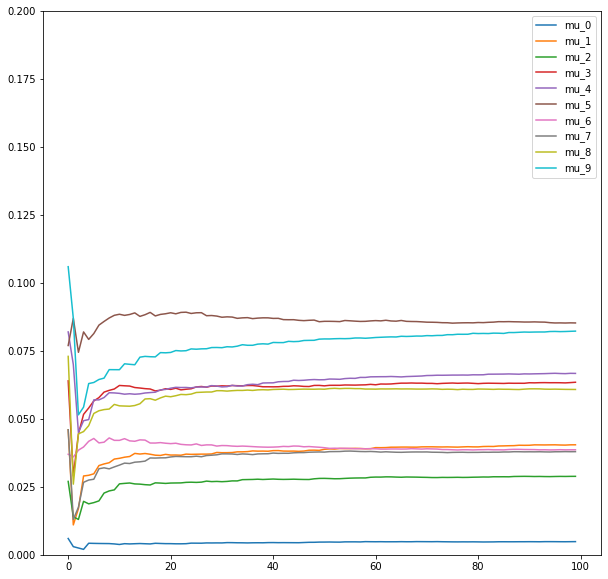

In [19]:
pd.DataFrame(historical_mu_hat, columns=[f'mu_{i}' for i in range(M)]).plot(figsize=(10, 10), ylim=(0,.2))

In [20]:
mu_hat

array([0.00486, 0.04045, 0.02888, 0.06345, 0.06683, 0.08537, 0.03869,
       0.03788, 0.0609 , 0.08228])

In [21]:
rho

array([0.006, 0.049, 0.034, 0.066, 0.074, 0.077, 0.034, 0.04 , 0.065,
       0.095])

## Analisis de la probabilidad de subreporte

In [3]:
from discoveryV2 import P_k_given_k_tilde, get_k_value

In [9]:
# from scipy.special import comb
from scipy.stats import binom

In [101]:
def P_k_given_k_tilde(k, k_tilde, arm_index):
    i = arm_index
    first_term = binom.pmf(k_tilde, N, rho[i] * q[i])
    second_term = binom.pmf(k, N, rho[i])
    third_term = binom.pmf(k_tilde, k, q[i])
    
    p = third_term * (second_term / first_term)

    return p

26


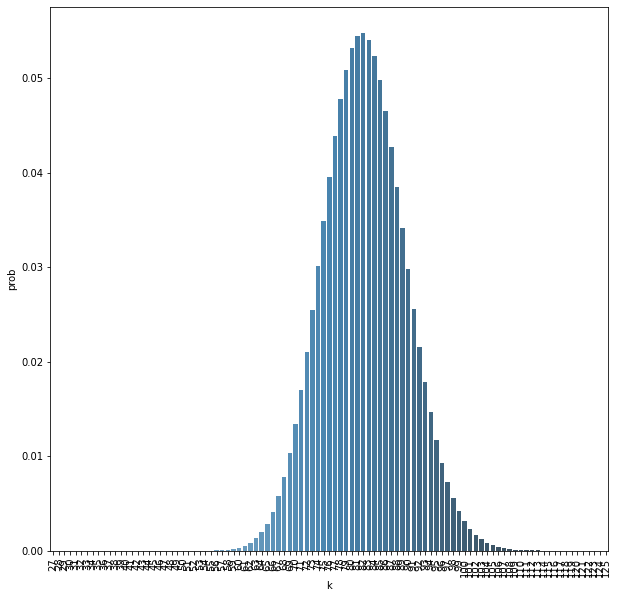

In [16]:
arm_idx = 4
k_tilde = np.random.binomial(N, rho[arm_idx] * q[arm_idx])
# k_tilde = int(N * rho[arm_idx] * q[arm_idx])
max_value_k = k_tilde + 100

print(k_tilde)
data = pd.DataFrame({
    'k': range(k_tilde+1, max_value_k),
    'prob': [P_k_given_k_tilde(k, k_tilde, N, rho[arm_idx], q[arm_idx]) 
                    for k in range(k_tilde+1, max_value_k)]
})

plt.figure(figsize=(10, 10))
sns.barplot(data=data, x='k', y='prob', palette='Blues_d')
plt.xticks(rotation=90);

In [13]:
get_k_value(k_tilde, N, rho[arm_idx], q[arm_idx])

73

In [13]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = llr.initialization(T_i)

for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat

    #oracle
    a = ucb1.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = ucb1.update_mu_hat(X_T, a, t, S_T, historical_mu_hat[0])
    

<AxesSubplot:>

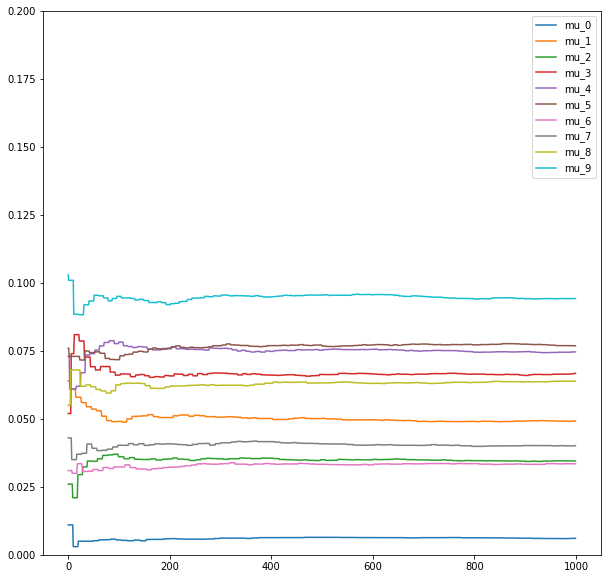

In [14]:
pd.DataFrame(historical_mu_hat, columns=[f'mu_{i}' for i in range(M)]).plot(figsize=(10, 10), ylim=(0,.2))

## Learning with Linear Rewards (LLR)

In [6]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = llr.initialization(T_i)

for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat

    #oracle
    a = llr.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = llr.update_mu_hat(X_T, a, t, S_T, historical_mu_hat[0])
    

<AxesSubplot:>

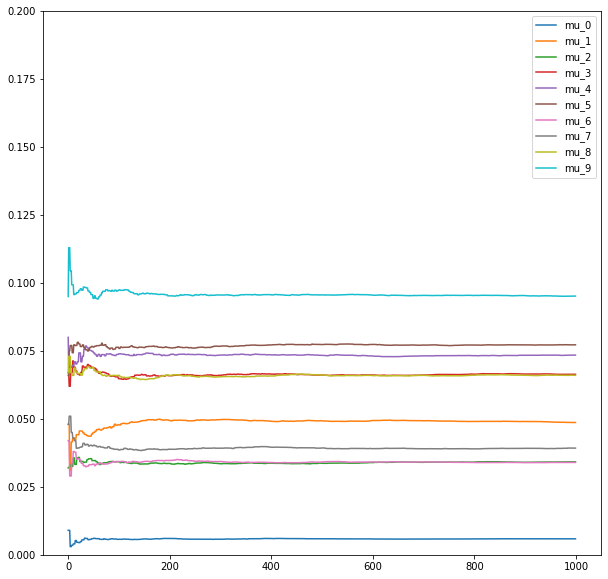

In [7]:
pd.DataFrame(historical_mu_hat, columns=[f'mu_{i}' for i in range(M)]).plot(figsize=(10, 10), ylim=(0,.2))

In [7]:
rho

array([0.006, 0.049, 0.034, 0.066, 0.074, 0.077, 0.034, 0.04 , 0.065,
       0.095])

In [8]:
mu_hat.tolist()

[0.007,
 0.047,
 0.034,
 0.067,
 0.07433799999999993,
 0.07691699999999997,
 0.038,
 0.039,
 0.07,
 0.09477799999999964]

## Chen

In [27]:
historical_mu_hat[100]

array([0.00728   , 0.049     , 0.03525   , 0.06554839, 0.071875  ,
       0.07524242, 0.03371429, 0.04010714, 0.06358065, 0.09328571])

In [29]:
mu_hat_sub = [0.00393, 0.03735, 0.02834, 0.05774, 0.06055, 0.07997, 0.03745, 0.03699, 0.06455, 0.08777]
mu_hat_rep = [0.00728   , 0.049     , 0.03525   , 0.06554839, 0.071875, 0.07524242, 0.03371429, 0.04010714, 0.06358065, 0.09328571]

In [30]:
print(np.linalg.norm(rho - mu_hat_rep))
print(np.linalg.norm(rho - mu_hat_sub))

0.004006996114148354
0.022437290388993055


In [26]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes
mu_hat = np.ones(M)

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

historical_mu_bar = np.zeros((T_max, M))
for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat

    # update rule
    mu_bar = chen.update_rule(t, mu_hat, T_i)
    historical_mu_bar[t - 1] = mu_bar
    
    #oracle
    S = chen.oracle(mu_bar)

    # 0-index
    S_T[t - 1] = S
    T_i[S.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = chen.update_mu_hat_t_i(S, X_T, t, S_T)
    
    

<AxesSubplot:>

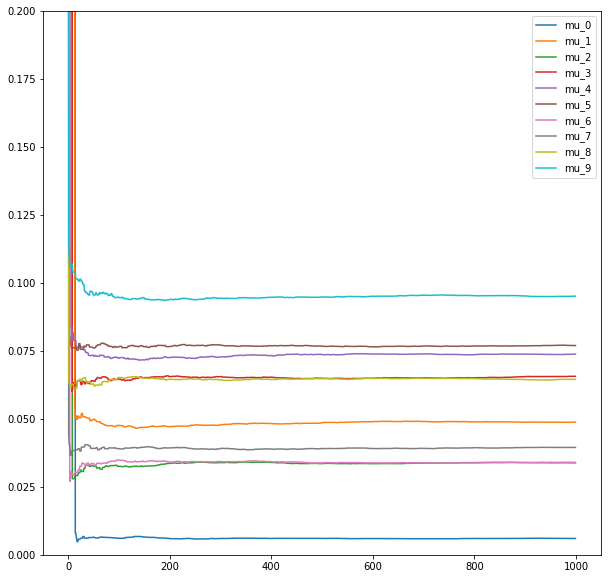

In [9]:
pd.DataFrame(historical_mu_hat, columns=[f'mu_{i}' for i in range(M)]).plot(figsize=(10, 10), ylim=(0,.2))


In [22]:
rho

array([0.006, 0.049, 0.034, 0.066, 0.074, 0.077, 0.034, 0.04 , 0.065,
       0.095])

In [23]:
mu_hat

array([0.00594653, 0.04897061, 0.03387803, 0.06585934, 0.07388295,
       0.07704216, 0.03385289, 0.03978243, 0.06511632, 0.09497066])

In [121]:
# pd.Series(q, index=[f'q_{i}' for i in range(M)])

In [35]:
np.ma.array([2,3], mask=[True, False]).mean()

3.0

In [33]:
np.ma.array(X_T, mask=S_T.astype(bool))
# .mean(axis=0).data / (mu_hat)

masked_array(
  data=[[0.0, 0.015, 0.007, 0.03, 0.018, 0.071, 0.028, --, --, --],
        [0.002, 0.012, 0.01, 0.024, 0.014, 0.052, 0.026, --, --, --],
        [0.001, 0.013, 0.007, 0.029, --, --, --, 0.011, 0.019, 0.021],
        [0.0, 0.01, 0.01, 0.033, 0.023, 0.06, 0.02, --, --, --],
        [0.001, 0.018, 0.01, 0.03, --, --, --, 0.011, 0.026, 0.015],
        [0.0, 0.015, 0.014, 0.032, 0.022, 0.056, --, 0.015, --, --],
        [0.0, 0.018, 0.005, 0.032, 0.014, --, --, --, 0.024, 0.011],
        [0.0, 0.011, 0.01, --, --, --, 0.035, 0.011, 0.018, 0.012],
        [0.002, 0.004, --, --, --, 0.049, 0.035, 0.015, 0.018, 0.014],
        [0.001, 0.009, 0.01, --, 0.018, --, 0.034, 0.009, 0.026, --],
        [0.001, 0.014, 0.008, --, --, 0.065, 0.027, 0.017, --, 0.012],
        [0.001, 0.009, 0.009, --, 0.019, 0.05, --, --, 0.024, 0.02],
        [--, --, --, 0.03, 0.027, 0.065, 0.039, 0.011, 0.023, 0.018],
        [--, --, --, 0.027, 0.018, 0.066, 0.037, 0.014, 0.026, 0.012],
        [--, --

In [32]:
q

array([0.24434285, 0.25987554, 0.28116849, 0.46284169, 0.23340091,
       0.76706421, 0.81995656, 0.39747625, 0.31644109, 0.15551206])

In [ ]:
mu_hat * N